# Column selection and tuning

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn import tree
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_2012 = pd.read_csv('/content/drive/Shareddrives/255Project/archive.zip (Unzipped Files)/2012.csv')

In [ ]:
data_2012.head()

,_STATE,_GEOSTR,_DENSTR2,PRECALL,REPNUM,REPDEPTH,FMONTH,IDATE,IMONTH,IDAY,IYEAR,INTVID,DISPCODE,SEQNO,_PSU,NATTMPTS,NRECSEL,NRECSTR,CTELENUM,PVTRESID,COLGHOUS,CELLFON,LADULT,NUMADULT,NUMMEN,NUMWOMEN,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,CVDINFR4,CVDCRHD4,CVDSTRK3,ASTHMA3,ASTHNOW,...,_MRACE,RACE2,_RACEG2,_RACEGR2,_RACE_G,_CNRACE,_CNRACEC,_AGEG5YR,_AGE65YR,_AGE_G,HTIN4,HTM4,WTKG3,_BMI5,_BMI5CAT,_RFBMI5,_CHLDCNT,_EDUCAG,_INCOMG,_SMOKER3,_RFSMOK3,DRNKANY5,DROCDY3_,_RFBING5,_DRNKDY4,_DRNKMO4,_RFDRHV4,_RFDRMN4,_RFDRWM4,_FLSHOT5,_PNEUMO2,_RFSEAT2,_RFSEAT3,_RFMAM2Y,_MAM502Y,_RFPAP32,_RFPSA21,_RFBLDS2,_RFSIGM2,_AIDTST3
0,1.0,7.0,1.0,1.0,20118.0,3.0,2.0,b'02162012',b'02',b'16',b'2012',b'00163',1100.0,2.012001e+09,2.012001e+09,8.0,2585.0,45328.0,1.0,1.0,NaN,1.0,NaN,2.0,1.000000e+00,1.0,3.0,77.0,88.0,88.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,1.0,5.0,72.0,183.0,8618.0,2577.0,3.0,2.0,3.0,3.0,4.0,4.0,1.0,2.0,5.397605e-79,1.0,5.397605e-79,5.397605e-79,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0,2.0
1,1.0,8.0,1.0,1.0,10119.0,17.0,1.0,b'01052012',b'01',b'05',b'2012',b'00172',1100.0,2.012001e+09,2.012001e+09,2.0,3284.0,162814.0,1.0,1.0,NaN,1.0,NaN,4.0,1.000000e+00,3.0,1.0,88.0,88.0,NaN,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,1.0,4.0,66.0,168.0,7938.0,2825.0,3.0,2.0,1.0,4.0,5.0,4.0,1.0,1.0,1.000000e+01,1.0,2.000000e+01,6.000000e+00,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,2.0,1.0,1.0
2,1.0,8.0,2.0,1.0,10126.0,5.0,1.0,b'01032012',b'01',b'03',b'2012',b'00105',1100.0,2.012001e+09,2.012001e+09,1.0,5535.0,399986.0,1.0,1.0,NaN,1.0,NaN,1.0,5.397605e-79,1.0,4.0,2.0,2.0,88.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,10.0,2.0,6.0,67.0,170.0,11340.0,3916.0,4.0,2.0,1.0,4.0,9.0,3.0,1.0,1.0,7.000000e+00,1.0,9.900000e+03,9.999000e+03,9.0,NaN,9.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,9.0,1.0,2.0
3,1.0,8.0,1.0,1.0,10128.0,9.0,1.0,b'01192012',b'01',b'19',b'2012',b'00106',1100.0,2.012001e+09,2.012001e+09,2.0,3284.0,162814.0,1.0,1.0,NaN,1.0,NaN,2.0,1.000000e+00,1.0,3.0,88.0,88.0,NaN,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,2.0,6.0,65.0,165.0,6577.0,2413.0,2.0,1.0,1.0,1.0,2.0,4.0,1.0,2.0,5.397605e-79,1.0,5.397605e-79,5.397605e-79,1.0,NaN,1.0,2.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0,2.0,2.0
4,1.0,8.0,1.0,1.0,10130.0,26.0,1.0,b'01062012',b'01',b'06',b'2012',b'00102',1100.0,2.012001e+09,2.012001e+09,1.0,3284.0,162814.0,1.0,1.0,NaN,1.0,NaN,2.0,1.000000e+00,1.0,4.0,15.0,88.0,88.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,1.0,5.0,66.0,168.0,12927.0,4600.0,4.0,2.0,1.0,2.0,9.0,4.0,1.0,2.0,5.397605e-79,1.0,5.397605e-79,5.397605e-79,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,2.0,1.0,2.0


In [ ]:
L = []
for i in data_2012.columns:
    if i.startswith('_'):
        L.append(i)

In [ ]:
data_2012.drop(L, axis=1, inplace = True)

In [ ]:
data_2012_male = data_2012.loc[data_2012.SEX.isin([1])]

In [ ]:
data_2012_male.SEX

0         1.0
1         1.0
5         1.0
7         1.0
8         1.0
         ... 
475673    1.0
475675    1.0
475677    1.0
475681    1.0
475684    1.0
Name: SEX, Length: 191737, dtype: float64

In [ ]:
data_2012_male['DIABETE3'].value_counts()

3.0    163227
1.0     25037
4.0      3039
7.0       267
9.0       167
Name: DIABETE3, dtype: int64

In [ ]:
data_2012_female = data_2012.loc[data_2012.SEX.isin([2])]

In [ ]:
data_2012_female.SEX

2         2.0
3         2.0
4         2.0
6         2.0
9         2.0
         ... 
475680    2.0
475682    2.0
475683    2.0
475685    2.0
475686    2.0
Name: SEX, Length: 283950, dtype: float64

In [ ]:
data_2012_female['DIABETE3'].value_counts()

3.0    240072
1.0     34726
4.0      4696
2.0      4067
7.0       297
9.0        92
Name: DIABETE3, dtype: int64

In [ ]:
data_counts_f = pd.DataFrame.from_dict(data_2012_female['DIABETE3'].value_counts())
data_counts_f = data_counts_f.rename(columns={"DIABETE3": "Female"})
data_counts_f.head()

,Female
3.0,240072
1.0,34726
4.0,4696
2.0,4067
7.0,297


In [ ]:
data_counts = pd.DataFrame.from_dict(data_2012_male['DIABETE3'].value_counts())
data_counts = data_counts.rename(columns={"DIABETE3": "Male"})
data_counts.head()

,Male
3.0,163227
1.0,25037
4.0,3039
7.0,267
9.0,167


In [ ]:
#data_counts.merge(data_counts_f)

In [ ]:
'''plt.figure(figsize=[1440,2160])

y = data_2012_male['DIABETE3'].value_counts()
x = data_2012_female['DIABETE3'].value_counts()

n_groups = 6
n_groups_m = 5
fig, ax = plt.subplots()
index_f = np.arange(n_groups)
index_m = np.arange(n_groups_m)
bar_width = 0.8
opacity = 0.3

rects1 = plt.bar(index_f, x, bar_width,
alpha=opacity,
color='b',
label='Diabetes Female')

rects2 = plt.bar(index_m, y, bar_width,
alpha=opacity,
color='g',
label='Diabetes Male')

plt.xlabel('Sex')
plt.ylabel('Diabetes count')
plt.title('Avg age grouped by gender')
plt.xticks(index_f,('Female','Male'))
plt.legend()

plt.tight_layout()
plt.show()'''

"plt.figure(figsize=[1440,2160])\n\ny = data_2012_male['DIABETE3'].value_counts()\nx = data_2012_female['DIABETE3'].value_counts()\n\nn_groups = 6\nn_groups_m = 5\nfig, ax = plt.subplots()\nindex_f = np.arange(n_groups)\nindex_m = np.arange(n_groups_m)\nbar_width = 0.8\nopacity = 0.3\n\nrects1 = plt.bar(index_f, x, bar_width,\nalpha=opacity,\ncolor='b',\nlabel='Diabetes Female')\n\nrects2 = plt.bar(index_m, y, bar_width,\nalpha=opacity,\ncolor='g',\nlabel='Diabetes Male')\n\nplt.xlabel('Sex')\nplt.ylabel('Diabetes count')\nplt.title('Avg age grouped by gender')\nplt.xticks(index_f,('Female','Male'))\nplt.legend()\n\nplt.tight_layout()\nplt.show()"

In [ ]:
def pred_method(data):
  pred_set = data.loc[data.DIABETE3.isin([7,9])]
  full_set = data.loc[data.DIABETE3.isin([1,2,3,4])]
  full_set.drop(full_set.std()[(full_set.std() == 0)].index, axis=1,inplace = True)
  pred_target = pred_set[['DIABETE3']]
  training_target = full_set[['DIABETE3']]  
  full_set.drop(columns=['DIABETE3'],inplace=True)
  pred_set.drop(columns=['DIABETE3'],inplace=True)
  full_set = full_set.select_dtypes(exclude=['object'])
  x = full_set.fillna(-1)
  corr_matrix = x.corr().abs()
  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  
  # Find features with correlation greater than 0.95
  to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
  full_set.drop(to_drop, axis=1,inplace = True)
  full_set.drop(['DIABAGE2', 'PREDIAB1','BLDSUGAR','FEETCHK2','FEETCHK','DOCTDIAB','PREDIAB1','CHKHEMO3'], axis=1,inplace = True)
  training_target['DIABETE3'].replace(4, 3, inplace=True)
  training_target['DIABETE3'].replace(2, 1, inplace=True)
  model = XGBClassifier() 
  X_train, X_test, y_train, y_test = train_test_split(full_set, training_target,shuffle = True, test_size=0.2, random_state=42)
  model.fit(X_train,y_train)
  sorted_idx = model.feature_importances_.argsort()
  plt.figure(figsize=(10,30))
  plt.barh(full_set.columns[sorted_idx], model.feature_importances_[sorted_idx])  
  print("Detailed classification report:")
  print()
  y_true, y_pred = y_test, model.predict(X_test)
  print(classification_report(y_true, y_pred))
  print()
  return full_set.columns[sorted_idx][-60:]

Detailed classification report:

              precision    recall  f1-score   support

         1.0       0.81      0.48      0.61      4963
         3.0       0.93      0.98      0.95     33298

    accuracy                           0.92     38261
   macro avg       0.87      0.73      0.78     38261
weighted avg       0.91      0.92      0.91     38261




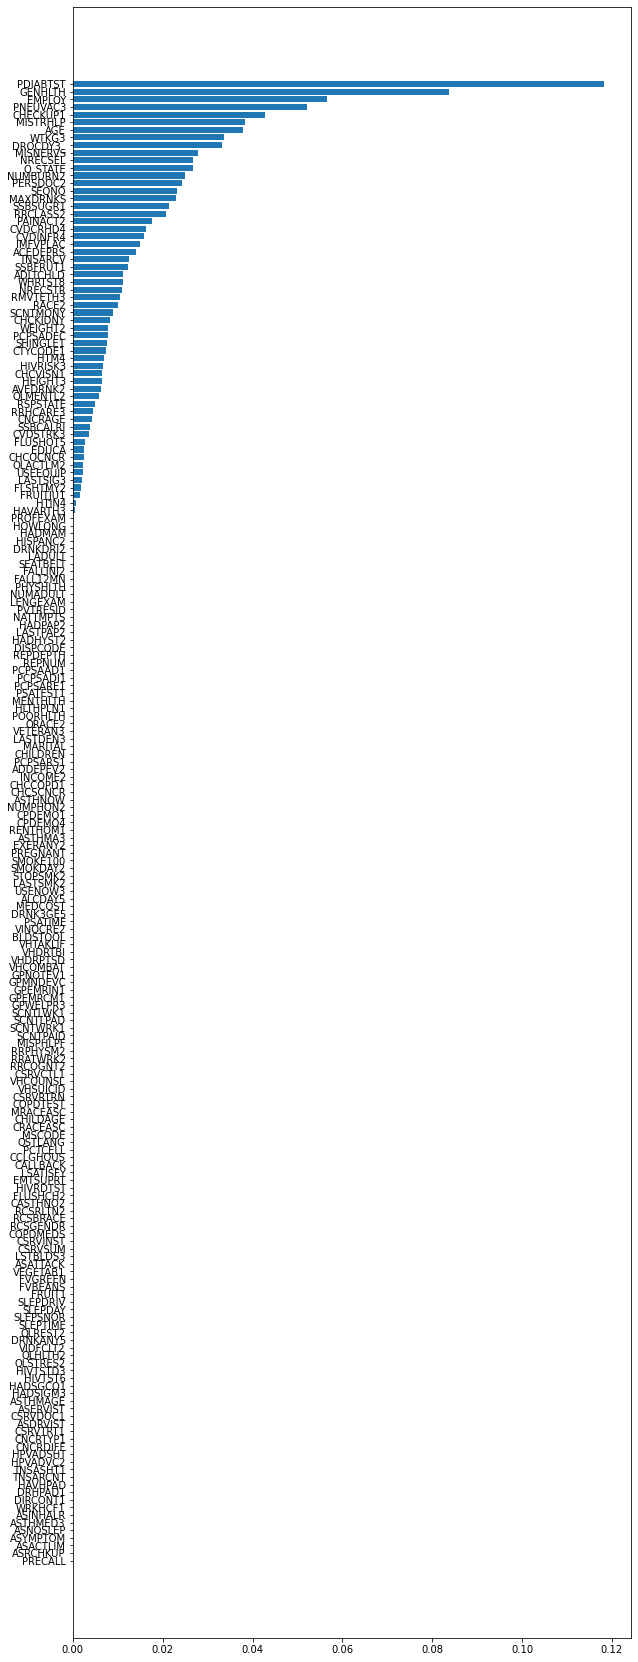

In [ ]:
sorted_col_m = pred_method(data_2012_male)

In [ ]:
sorted_col_m = sorted_col_m.insert(len(sorted_col_m),'DIABETE3')

In [ ]:
final_m_df = data_2012_male[sorted_col_m]

In [ ]:
final_m_df.to_csv('final_m_dia.csv',index=False)

Detailed classification report:

              precision    recall  f1-score   support

         1.0       0.82      0.44      0.58      7709
         3.0       0.92      0.99      0.95     49004

    accuracy                           0.91     56713
   macro avg       0.87      0.71      0.76     56713
weighted avg       0.91      0.91      0.90     56713




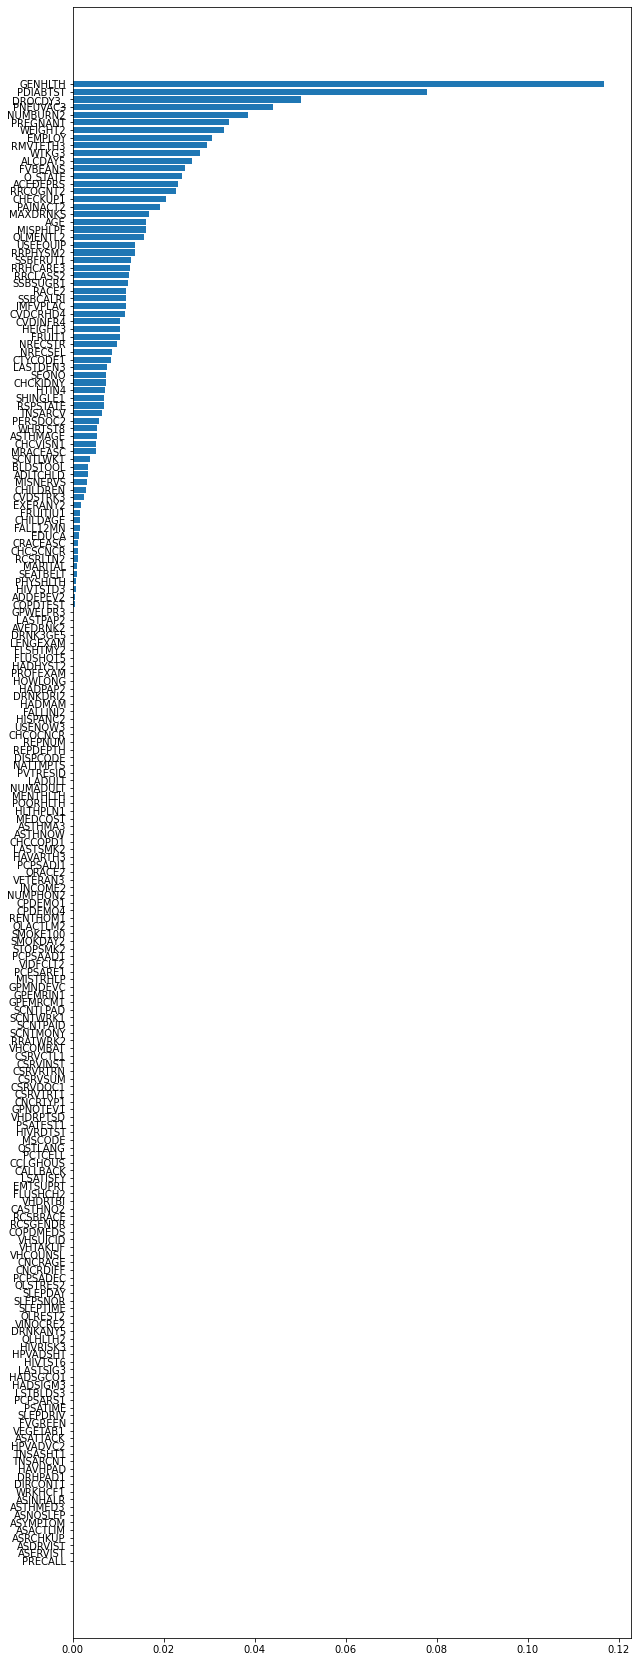

In [ ]:
sorted_col_f = pred_method(data_2012_female)

In [ ]:
sorted_col_f = sorted_col_f.insert(len(sorted_col_f),'DIABETE3')

In [ ]:
final_f_df = data_2012_female[sorted_col_f]
final_f_df.shape

(283950, 62)

In [ ]:
final_f_df.to_csv('final_f_dia.csv',index=False)

# Data Visualizations

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_f = pd.read_csv('/content/drive/Shareddrives/255Project/final_f_dia.csv')

In [ ]:
data_f.drop(['DIABETE3.1'],axis=1,inplace = True)

data_f.head()

,EDUCA,FALL12MN,CHILDAGE,FRUITJU1,EXERANY2,CVDSTRK3,CHILDREN,MISNERVS,ADLTCHLD,BLDSTOOL,SCNTLWK1,MRACEASC,CHCVISN1,ASTHMAGE,WHRTST8,PERSDOC2,TNSARCV,RSPSTATE,SHINGLE1,HTIN4,CHCKIDNY,SEQNO,LASTDEN3,CTYCODE1,NRECSEL,NRECSTR,FRUIT1,HEIGHT3,CVDINFR4,CVDCRHD4,IMFVPLAC,SSBCALRI,RACE2,SSBSUGR1,RRCLASS2,RRHCARE3,SSBFRUT1,RRPHYSM2,USEEQUIP,QLMENTL2,MISPHLPF,AGE,MAXDRNKS,PAINACT2,CHECKUP1,RRCOGNT2,ACEDEPRS,O_STATE,FVBEANS,ALCDAY5,WTKG3,RMVTETH3,EMPLOY,WEIGHT2,PREGNANT,NUMBURN2,PNEUVAC3,DROCDY3_,PDIABTST,GENHLTH,DIABETE3
0,6.0,88.0,NaN,NaN,2.0,2.0,88.0,NaN,1.000000e+00,1.0,NaN,2.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,67.0,1.0,2.012001e+09,1.0,1.0,5535.0,399986.0,NaN,507.0,2.0,1.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,68.0,77.0,NaN,1.0,NaN,NaN,1.0,NaN,202.0,11340.0,2.0,7.0,250.0,NaN,NaN,1.0,7.000000e+00,1.0,4.0,3.0
1,3.0,88.0,NaN,NaN,2.0,2.0,88.0,NaN,5.397605e-79,2.0,NaN,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,65.0,2.0,2.012001e+09,4.0,1.0,3284.0,162814.0,NaN,505.0,2.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,72.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,888.0,6577.0,3.0,8.0,145.0,NaN,NaN,2.0,5.397605e-79,2.0,3.0,3.0
2,4.0,88.0,NaN,NaN,1.0,2.0,88.0,NaN,5.397605e-79,2.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,66.0,2.0,2.012001e+09,1.0,1.0,3284.0,162814.0,NaN,506.0,2.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,60.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,888.0,12927.0,1.0,7.0,285.0,NaN,NaN,2.0,5.397605e-79,NaN,4.0,1.0
3,6.0,NaN,145.0,NaN,1.0,2.0,3.0,NaN,5.397605e-79,NaN,NaN,2.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,67.0,2.0,2.012001e+09,1.0,1.0,3284.0,162814.0,NaN,507.0,2.0,2.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,36.0,2.0,NaN,1.0,NaN,NaN,1.0,NaN,204.0,7484.0,8.0,1.0,165.0,2.0,NaN,2.0,1.300000e+01,1.0,3.0,3.0
4,6.0,88.0,NaN,NaN,1.0,2.0,88.0,NaN,5.397605e-79,1.0,NaN,1.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,63.0,2.0,2.012001e+09,1.0,1.0,3284.0,162814.0,NaN,503.0,2.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,68.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,888.0,6350.0,1.0,7.0,140.0,NaN,NaN,1.0,5.397605e-79,1.0,2.0,3.0


In [ ]:
data_m = pd.read_csv('/content/drive/Shareddrives/255Project/final_m_dia.csv')

In [ ]:
data_m.head()

,HADMAM,HOWLONG,PROFEXAM,HAVARTH3,HTIN4,FRUITJU1,FLSHTMY2,LASTSIG3,USEEQUIP,QLACTLM2,CHCOCNCR,EDUCA,FLUSHOT5,CVDSTRK3,SSBCALRI,CNCRAGE,RRHCARE3,RSPSTATE,QLMENTL2,AVEDRNK2,HEIGHT3,CHCVISN1,HIVRISK3,HTM4,CTYCODE1,SHINGLE1,PCPSADEC,WEIGHT2,CHCKIDNY,SCNTMONY,RACE2,RMVTETH3,NRECSTR,WHRTST8,ADLTCHLD,SSBFRUT1,TNSARCV,ACEDEPRS,IMFVPLAC,CVDINFR4,CVDCRHD4,PAINACT2,RRCLASS2,SSBSUGR1,MAXDRNKS,SEQNO,PERSDOC2,NUMBURN2,O_STATE,NRECSEL,MISNERVS,DROCDY3_,WTKG3,AGE,MISTRHLP,CHECKUP1,PNEUVAC3,EMPLOY,GENHLTH,PDIABTST,DIABETE3
0,NaN,NaN,NaN,1.0,72.0,NaN,NaN,NaN,2.0,2.0,2.0,5.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,600.0,1.0,2.0,183.0,1.0,NaN,NaN,190.0,2.0,NaN,1.0,1.0,45328.0,NaN,5.397605e-79,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,2.012001e+09,1.0,NaN,1.0,2585.0,NaN,5.397605e-79,8618.0,64.0,NaN,1.0,1.0,7.0,3.0,1.0,3.0
1,NaN,NaN,NaN,2.0,66.0,NaN,102011.0,1.0,2.0,2.0,2.0,6.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,2.0,506.0,2.0,2.0,168.0,1.0,NaN,NaN,175.0,2.0,NaN,1.0,8.0,162814.0,NaN,5.397605e-79,NaN,NaN,NaN,8.0,2.0,2.0,NaN,NaN,NaN,2.0,2.012001e+09,1.0,NaN,1.0,3284.0,NaN,1.000000e+01,7938.0,54.0,NaN,1.0,2.0,1.0,1.0,1.0,3.0
2,NaN,NaN,NaN,1.0,73.0,NaN,NaN,NaN,2.0,2.0,2.0,4.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,2.0,601.0,2.0,2.0,185.0,1.0,NaN,NaN,250.0,2.0,NaN,1.0,1.0,162814.0,NaN,5.397605e-79,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,3.0,2.012001e+09,1.0,NaN,1.0,3284.0,NaN,1.400000e+01,11340.0,53.0,NaN,1.0,2.0,1.0,3.0,2.0,3.0
3,NaN,NaN,NaN,1.0,69.0,NaN,NaN,2.0,1.0,1.0,2.0,6.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,4.0,509.0,2.0,2.0,175.0,1.0,NaN,NaN,210.0,2.0,NaN,1.0,8.0,162814.0,NaN,5.397605e-79,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,77.0,2.012001e+09,2.0,NaN,1.0,3284.0,NaN,8.300000e+01,9525.0,53.0,NaN,1.0,2.0,1.0,3.0,1.0,3.0
4,NaN,NaN,NaN,2.0,66.0,NaN,NaN,NaN,2.0,2.0,2.0,6.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,506.0,1.0,2.0,168.0,1.0,NaN,NaN,175.0,2.0,NaN,1.0,8.0,162814.0,NaN,5.397605e-79,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,2.012001e+09,1.0,NaN,1.0,3284.0,NaN,5.397605e-79,7938.0,55.0,NaN,3.0,2.0,1.0,2.0,1.0,3.0


In [ ]:
def gen_health(df_cv):
  df_cv['GENHLTH'].replace(2, 1, inplace=True)
  df_cv['GENHLTH'].replace(3, 1, inplace=True)
  df_cv['GENHLTH'].replace(4, 2, inplace=True)
  df_cv['GENHLTH'].replace(5, 2, inplace=True)
  df_cv['GENHLTH'].replace(7, np.NaN, inplace=True)
  df_cv['GENHLTH'].replace(9, np.NaN, inplace=True)
  df_cv['DIABETE3'].replace(4, 3, inplace=True)
  df_cv['DIABETE3'].replace(2, 1, inplace=True)
  df_cv['DIABETE3'].replace(7, np.nan, inplace=True)
  df_cv['DIABETE3'].replace(9, np.nan, inplace=True)
  df_cv['MAXDRNKS'].replace(77, np.nan, inplace=True)
  df_cv['MAXDRNKS'].replace(99, np.nan, inplace=True)
  
  

In [ ]:
data_f['PREGNANT'].replace(7, np.nan, inplace=True)
data_f['PREGNANT'].replace(9, np.nan, inplace=True)
data_f['CHILDREN'].replace(88, 0, inplace=True)
data_f['CHILDREN'].replace(99, np.nan, inplace=True)


In [ ]:
gen_health(data_m)
gen_health(data_f)

In [ ]:
def plot_cov(data):
  # Covariance matrix for female
  cov_matrix = data_f.corr().abs()
  # Heatmap of above Covariance matrix
  f, ax = plt.subplots(figsize=(30, 24))
  sns.heatmap(cov_matrix, mask=np.zeros_like(cov_matrix, dtype=np.bool),
  cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)#, annot=True

NameError: ignored

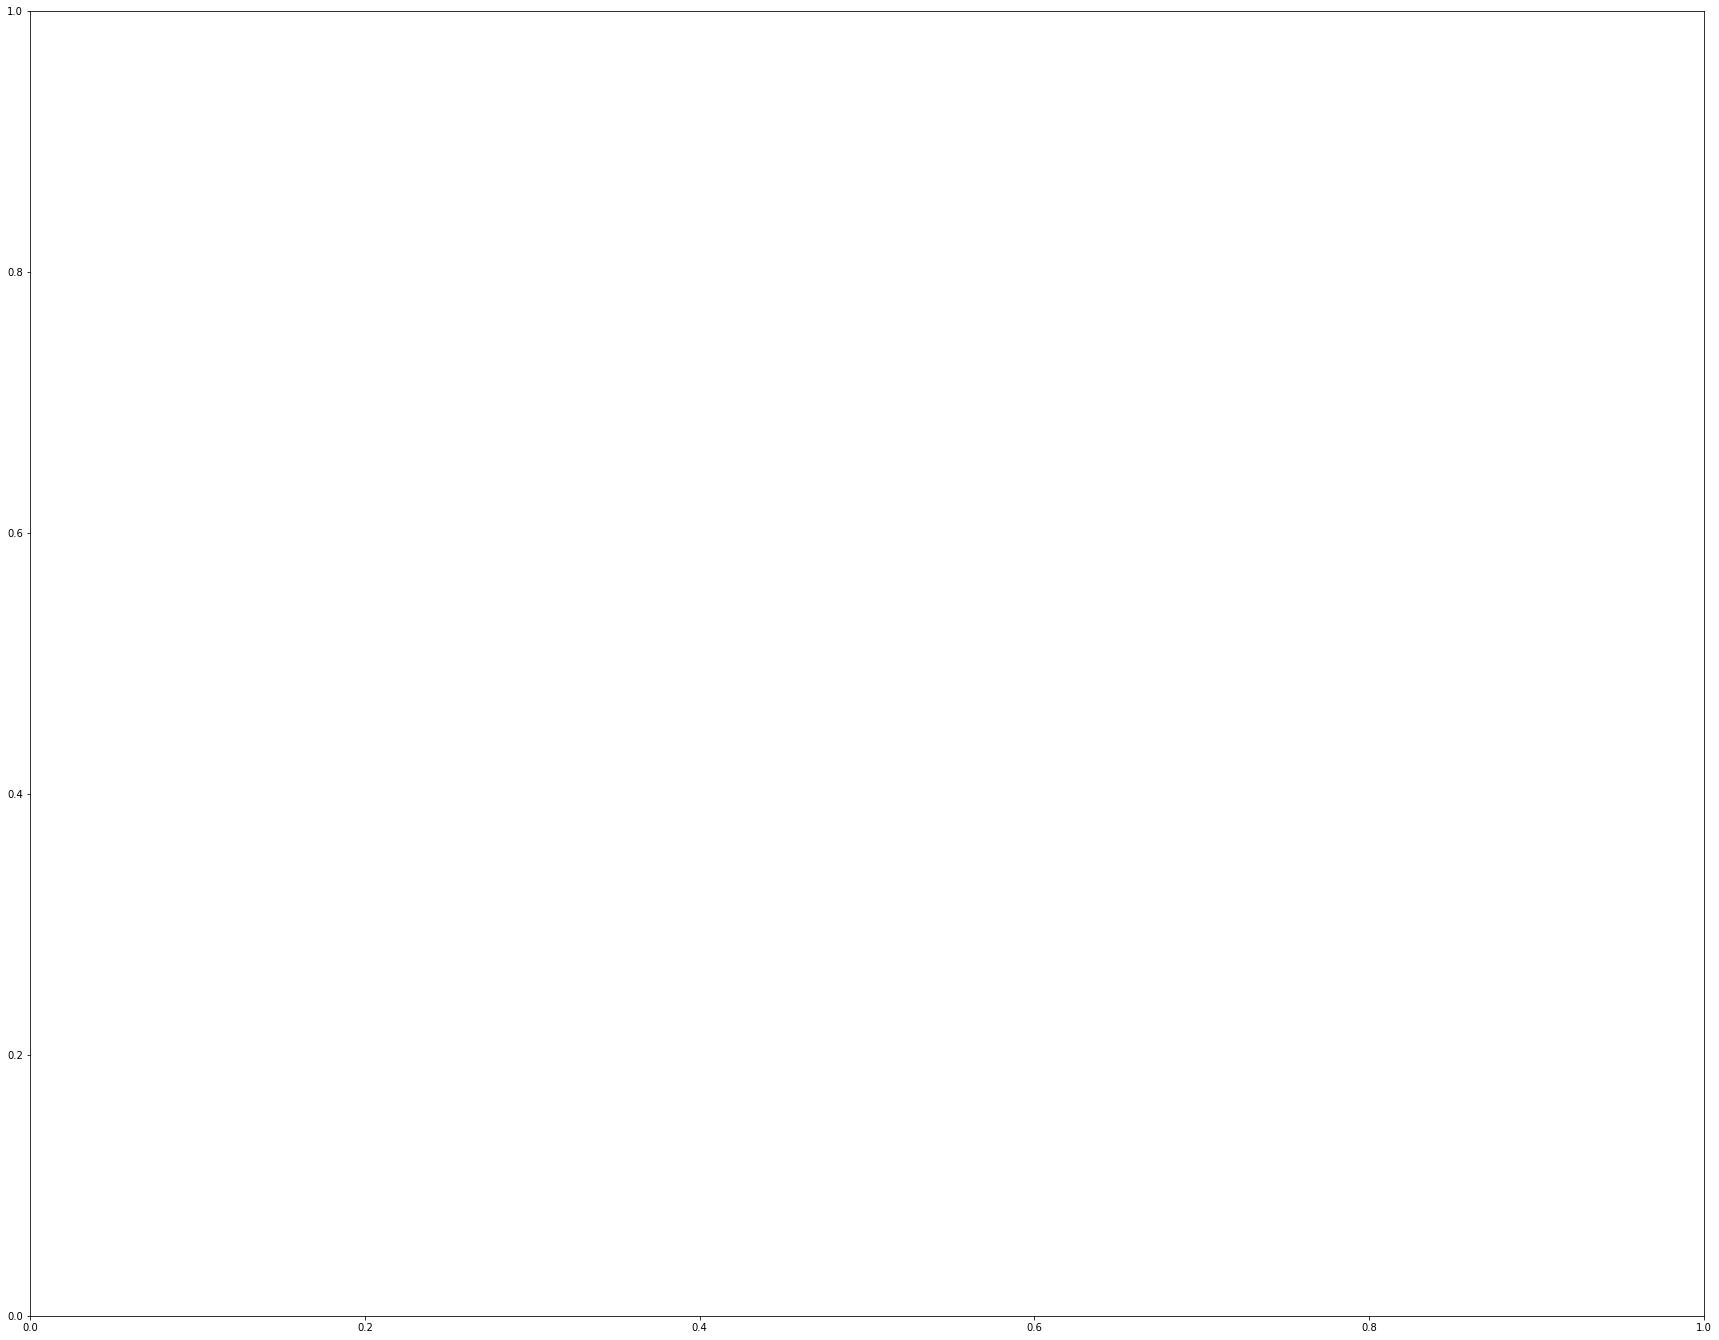

In [ ]:
plot_cov(data_f)

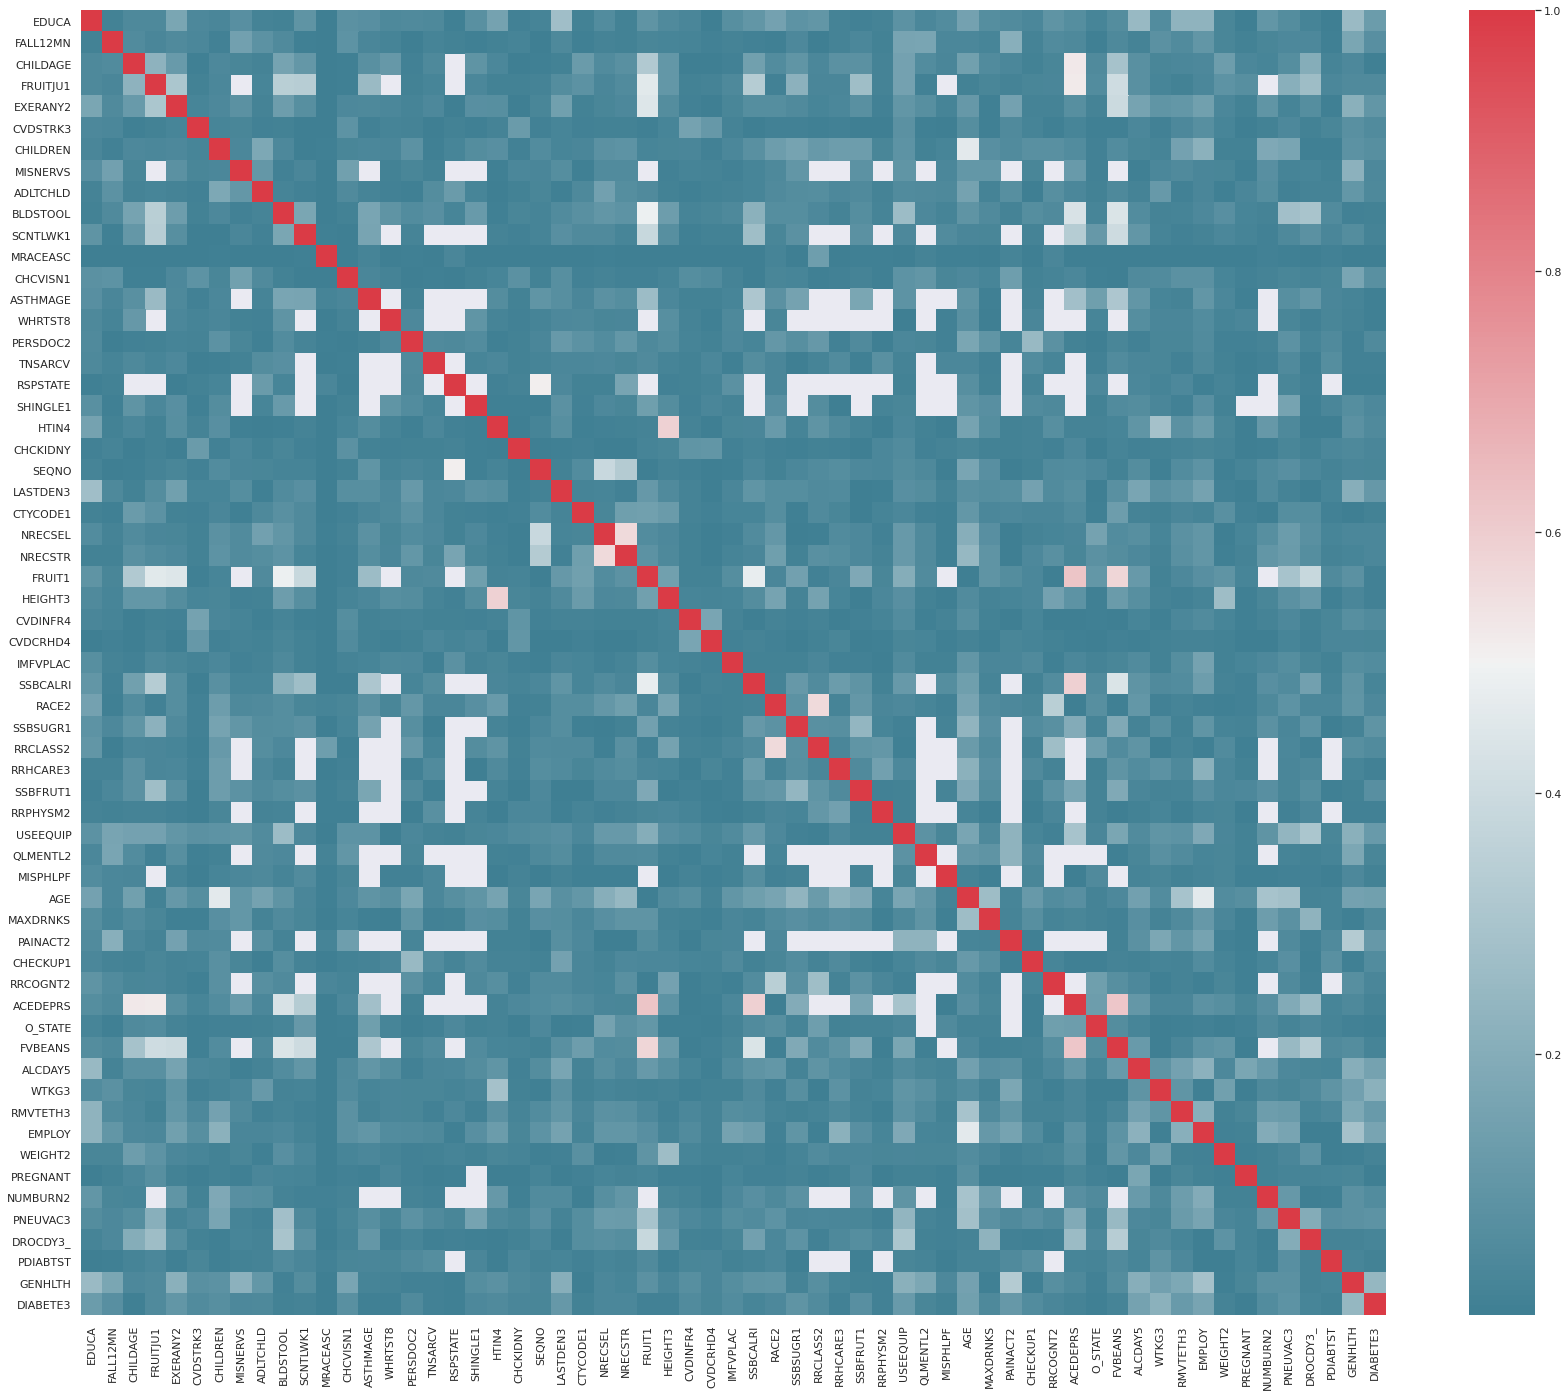

In [ ]:
plot_cov(data_m)

In [ ]:
def plot_dia_count(df_cv, xaxis):
  
  sns.set(rc={'figure.figsize':(6,6)})
  sns.countplot(df_cv[xaxis],label="Count")

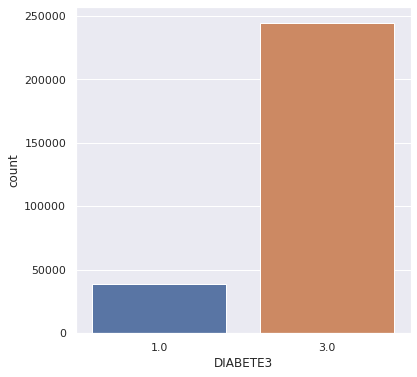

In [ ]:
plot_dia_count(data_f, 'DIABETE3')

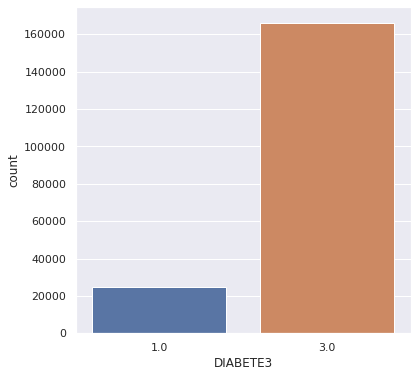

In [ ]:
plot_dia_count(data_m, 'DIABETE3')

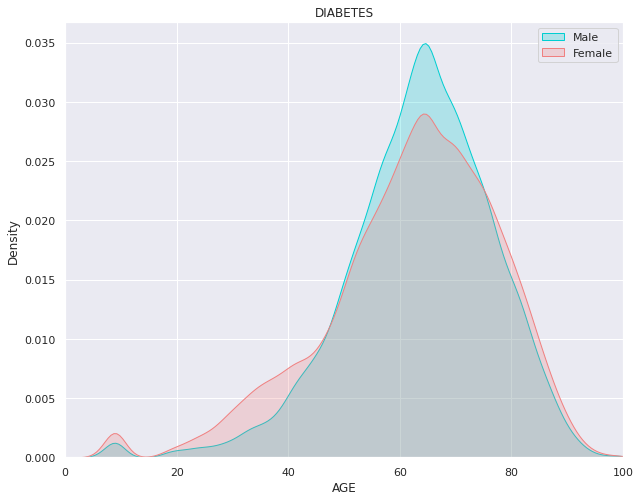

In [ ]:
plt.figure(figsize=(10,8))
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(
    data_m[data_m.DIABETE3 == 1].AGE,
    color="darkturquoise",
    shade=True
)

sns.kdeplot(
    data_f[data_f.DIABETE3 == 1].AGE,
    color="lightcoral",
    shade=True
)

plt.legend(['Male','Female'])
plt.title('DIABETES')
plt.xlim(0,100)
plt.show()

In [ ]:
def plot_dia_count(df_cv, xaxis, label1, label2):
  plt.figure(figsize=(10,8))
  k = df_cv.groupby([xaxis,'DIABETE3']).size()

  to_plot =k.unstack()
  to_plot_transpose = to_plot.transpose()
  to_plot_transpose_pct = to_plot_transpose.div(to_plot_transpose.sum())
  to_plot_pct=to_plot_transpose_pct.transpose()

  to_plot_pct.plot(kind='bar',stacked=True)
  positions = (0, 1)
  labels = (label1, label2)
  plt.xticks(positions, labels)
  plt.title("General Health on Diabetes")
  plt.ylabel('Percentage Count')
  plt.xlabel('Physical')
  plt.show()

<Figure size 720x576 with 0 Axes>

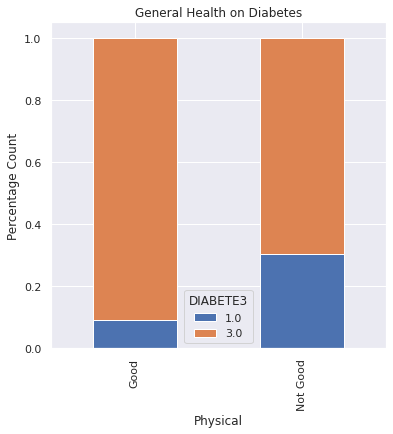

In [ ]:
plot_dia_count(data_m, 'GENHLTH', "Good", "Not Good")

<Figure size 720x576 with 0 Axes>

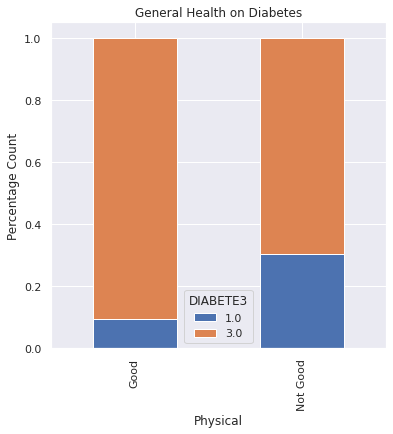

In [ ]:
plot_dia_count(data_f, 'GENHLTH', "Good", "Not Good")

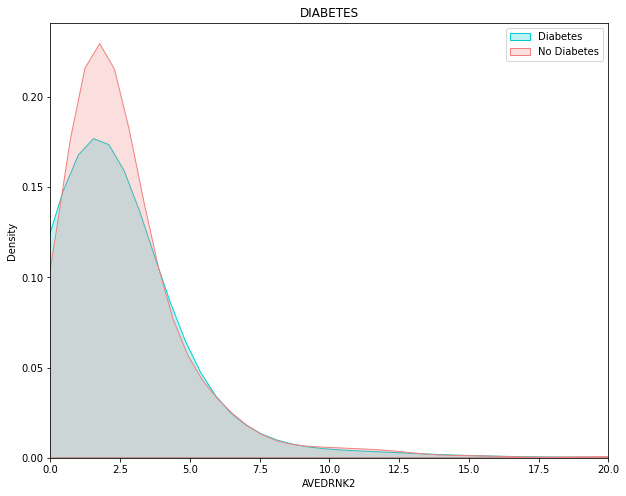

In [ ]:
plt.figure(figsize=(10,8))
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(
    data_m[data_m.DIABETE3 == 1].AVEDRNK2,
    color="darkturquoise",
    shade=True
)

sns.kdeplot(
    data_m[data_m.DIABETE3 == 3].AVEDRNK2,
    color="lightcoral",
    shade=True
)

plt.legend(['Diabetes','No Diabetes'])
plt.title('DIABETES')
plt.xlim(0,20)
plt.show()

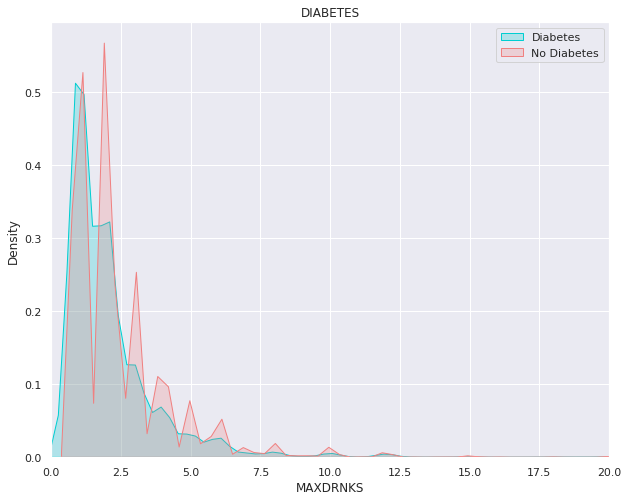

In [ ]:
plt.figure(figsize=(10,8))
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(
    data_f[data_f.DIABETE3 == 1].MAXDRNKS,
    color="darkturquoise",
    shade=True
)

sns.kdeplot(
    data_f[data_f.DIABETE3 == 3].MAXDRNKS,
    color="lightcoral",
    shade=True
)

plt.legend(['Diabetes','No Diabetes'])
plt.title('DIABETES')
plt.xlim(0,20)
plt.show()

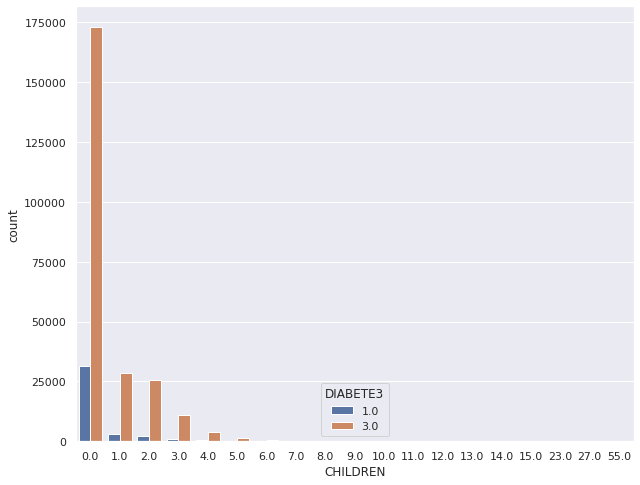

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(x='CHILDREN', hue='DIABETE3', data=data_f)

In [ ]:
data_f.groupby(['DIABETE3']).CHILDREN.count()

DIABETE3
1.0     38665
3.0    243872
Name: CHILDREN, dtype: int64

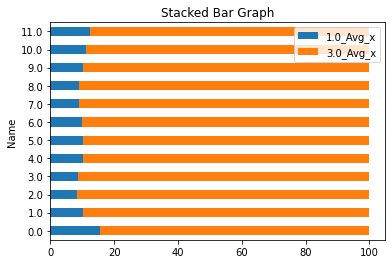

In [ ]:
x = data_f.groupby(['DIABETE3']).CHILDREN.value_counts()
stacked_df1 = pd.DataFrame(columns=['Name',1.0,'1.0_Avg','3.0_Avg'])
stacked_df2 = pd.DataFrame(columns=['Name',3.0,'1.0_Avg','3.0_Avg'])
for val, cnt in x.iteritems(): 
  if(val[0] == 1):
    stacked_df1 = stacked_df1.append({'Name': val[1], val[0]: cnt }, ignore_index=True)
  else:
    stacked_df2 = stacked_df2.append({'Name': val[1], val[0]: cnt }, ignore_index=True)
stacked_df = stacked_df1.merge(stacked_df2, on=['Name'], how='right')
for index, row in stacked_df.iterrows():
    stacked_df['1.0_Avg_x'].loc[index] = row[1.0]/(row[1.0]+row[3.0])*100
    stacked_df['3.0_Avg_x'].loc[index] = row[3.0]/(row[1.0]+row[3.0])*100
stacked_df.drop(['1.0_Avg_y','3.0_Avg_y'], axis=1, inplace=True)
stacked_df.dropna(axis=0,inplace = True)
stacked_df.drop([1.0,3.0], axis=1, inplace=True)
stacked_df.plot( 
    x = 'Name', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Graph', 
    mark_right = True) 